In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy import constants as c

# Load Data from Hipparcos catalog

Project from this article:
http://balbuceosastropy.blogspot.com/2014/03/construction-of-hertzsprung-russell.html

Query Data from this URL:
http://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/239/hip_main

Specifically looking for these fields (also adding RA and Dec)
* H1 Identifier (HIP)
* H5 V Johnson magnitude (Vmag)
* H11 Trigonometric parallax, expressed in units of milliarcsec (Plx)
* H37 Colour index (B-V)
* H76 Spectral type (SpType)

(including RAhms and DEdms for other potential work)

Note, can look up common star names from hipparcos here:
https://www.cosmos.esa.int/web/hipparcos/common-star-names

In [2]:
# Load data from Hipparcos
filename = 'hipparcos.tsv'
df_org = pd.read_table(filename, skiprows=48, sep=';', header=None, index_col=0,
                   names = ['HIP', 'RAhms', 'DEdms', 'Vmag', 'Plx', 'B-V', 'SpType'],
                   skipfooter=1, engine='python')

### Clean and format the data

In [3]:
# Replace empty fields with NaN.
df_clean = df_org.replace(r'^\s*$', np.nan, regex=True)
df_clean= df_clean.dropna()

# convert fields to float for later operations
df_clean['Vmag'] = df_clean['Vmag'].astype(np.float64)
df_clean['Plx'] = df_clean['Plx'].astype(np.float64)
df_clean['B-V'] = df_clean['B-V'].astype(np.float64)

# Some rows have 0 or negative parallax for some reason.
f = lambda s: (s > 0)
idx  = df_clean['Plx'].apply(f)
df_clean = df_clean[idx]

# Remove entries with special classes C, N, R, and S and keep only the main spectral classes of OBAFGKM
f = lambda s: s[0] in 'OBAFGKM'
df_clean = df_clean[df_clean['SpType'].map(f)]

# Shape should be (110357, 6)
df_clean.shape

(110357, 6)

###  Review of Distance via Parallax Angle (Plx).

Geometric relationship between parallax angle and distance to star is:

$$ tan(\theta) = \frac{L}{D} $$

Where L is the distance from the earth to Sun, and D is the distance to the Star.

Solving for D yields:

$$ D = \frac{L}{tan(\theta)} $$

A Parsec is defined as the distance at which 1 au (L) subtends an angle of one arcsecond ($\frac{1}{3600}$th of a degree), which is equivalent to 3.2615638 light years.


Given that we use parallax to measure distance to stars, $\theta$ is often small enough that we can assume that $tan(\theta)$ is equivalent to $\theta$.  Thus the distance computation in parsecs simplifies to

$$ D = \frac{1}{\theta} $$

Below is an example of how this works out.

In [4]:
# Taking the tangent.
theta = 1 * u.arcsec
D = c.au/np.tan(theta.to(u.rad))
print("{}".format(D.to(u.lyr)))

# Using the 1/theta approximation
D = (1 / theta.to(u.arcsec).value)* u.parsec
print("{}".format(D.to(u.lyr)))

# Compare using astropy constants
print("{}".format(c.pc.to(u.lyr)))

3.2615637771418795 lyr
3.2615637771674333 lyr
3.2615637771674333 lyr


### Compute Absolute Magnitude from Apparent Magnitude (Vmag) and Parallax Angle (Plx).

Apparent magnitude (m) is a measure of the brightness of a star or object observed from earth.  In the Hipparcos data set this is Vmag.

Absolute magnitude (M) is a measure of the brightness of a star or object observed from a standard distance of 10 parsecs.  

They are related by the following equation where D is the distance we observe the object from... typically earth:

$$ m = M - 5 + 5 * log_{10}(D) $$

In this case we know m (which is $V_{mag}$), and we know the distance through parallax angle $Plx$.

To solve for M:

$$ M = m + 5 - 5*log_{10}(\frac{1}{p}) $$

$$ M = m + 5 + 5*log_{10}(p) $$

$$ M = m + 5 * (1 + log_{10}(p)) $$

If parallax ($Plx$) is expressed in milliarcseconds (need to divide by 1000), and apparent magnitude as $V_{mag}$, then we get:

$$ M = V_{mag} + 5(1+log_{10}(\frac{Plx}{1000})) $$

Simplifing gives:

$$ M = V_{mag} + 5 * log_{10}(\frac{Plx}{100}) $$



In [5]:
# Add a new column with the absolute magnitude using the equation above.
df_clean['M_V'] = df_clean['Vmag'] + 5 * np.log10(df_clean['Plx']/100.)

# Plot Hertzsprung-Russell Diagram

HR diagrams have Absolute magnatude or Luminance on the y axis, and Spectral Class, Temperature, or B-V on the x axis.  This should be more or less equivalent.  Plotting B-V here to avoid trying to "digitize" spectral class.

In [6]:
# Helpers for Plots
def plot_spectral_class(df, b, c, label):
    ''' b: boolean Series to make the selection
        c: Color
        label: for the legend
    '''
    x = df['B-V'][b]
    y = df['M_V'][b]
    ax.scatter(x, y, c = c, s=6, edgecolors='none', label = label)
    
def plot_luminosity_class(df, b, c, label):
    ''' b: boolean Series to make the selection
        c: Color
        label: for the legend
    '''
    x = df['B-V'][b]
    y = df['M_V'][b]
    ax.scatter(x, y, c = c, s=6, edgecolors='none', label = label)


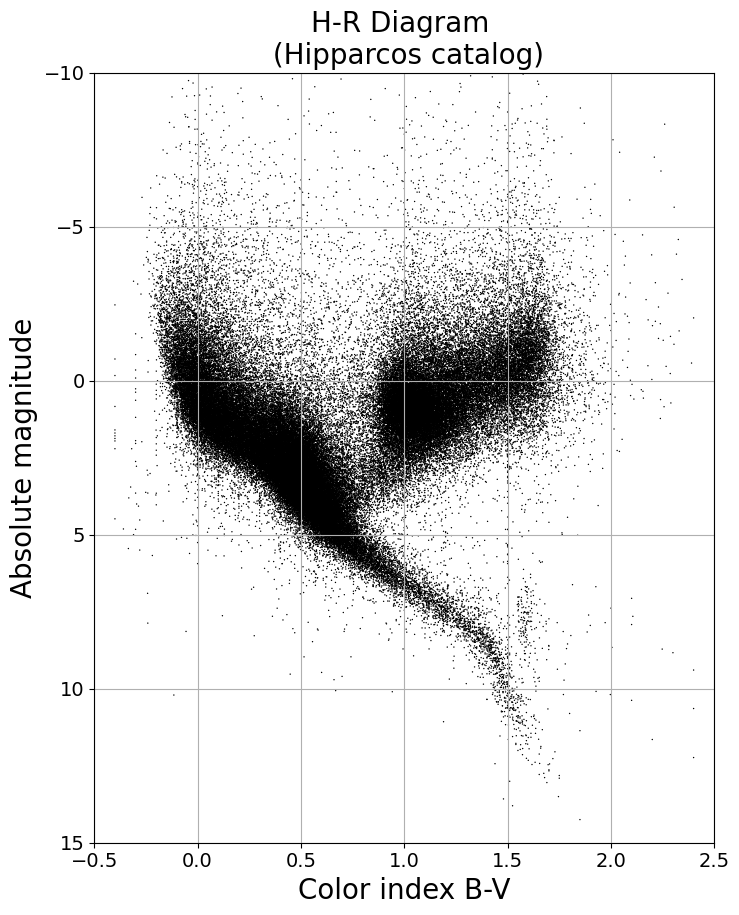

In [7]:
fig, ax = plt.subplots(figsize=(8,10))

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -10)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index B-V')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude')
ax.yaxis.label.set_fontsize(20)

ax.scatter(df_clean['B-V'], df_clean['M_V'],
#           s=50, edgecolors='none', alpha=0.015, c='k')
           s=1, edgecolors='none', c='k')

ax.tick_params(axis='both', labelsize=14)

### Explore Spectral Classes

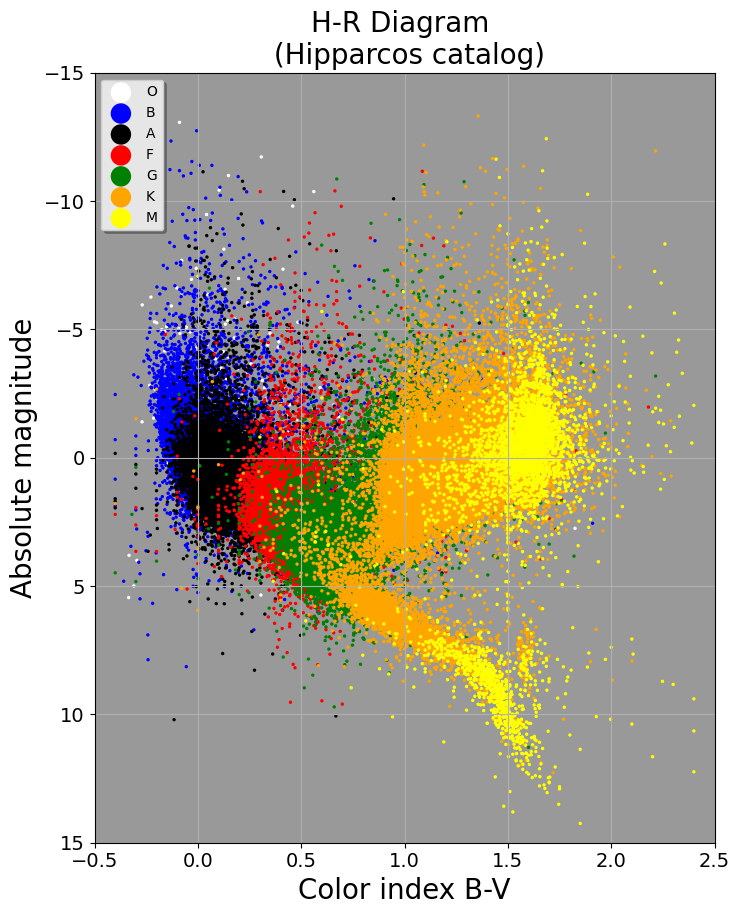

In [8]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111, facecolor='0.6')

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index B-V')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude')
ax.yaxis.label.set_fontsize(20)

#'OBAFGKM'
f = lambda s: s[0]=='O'
b = df_clean['SpType'].map(f)
plot_spectral_class(df_clean, b,'white', 'O')

f = lambda s: s[0]=='B'
b = df_clean['SpType'].map(f)
plot_spectral_class(df_clean, b,'blue', 'B')

f = lambda s: s[0]=='A'
b = df_clean['SpType'].map(f)
plot_spectral_class(df_clean, b,'black', 'A')

f = lambda s: s[0]=='F'
b = df_clean['SpType'].map(f)
plot_spectral_class(df_clean, b,'red', 'F')

f = lambda s: s[0]=='G'
b = df_clean['SpType'].map(f)
plot_spectral_class(df_clean, b,'green', 'G')

f = lambda s: s[0]=='K'
b = df_clean['SpType'].map(f)
plot_spectral_class(df_clean, b,'orange', 'K')

f = lambda s: s[0]=='M'
b = df_clean['SpType'].map(f)
plot_spectral_class(df_clean, b,'yellow', 'M')

ax.tick_params(axis='both', labelsize=14)
legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

### Explore Luminosity Classes

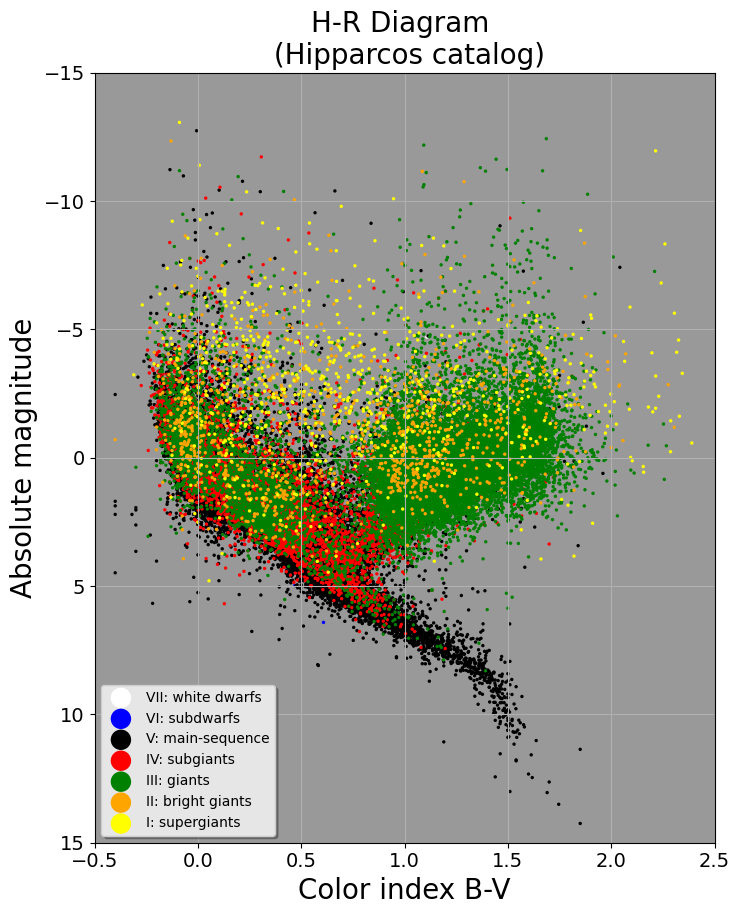

In [9]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111, facecolor='0.6')

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index B-V')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude')
ax.yaxis.label.set_fontsize(20)

f = lambda s: 'VII' in s
b = df_clean['SpType'].map(f)
plot_luminosity_class(df_clean, b,'white', 'VII: white dwarfs')

f = lambda s: ('VI' in s) and ('VII' not in s)
b = df_clean['SpType'].map(f)
plot_luminosity_class(df_clean, b,'blue', 'VI: subdwarfs')

f = lambda s: ('V' in s) and ('VI' not in s) and ('IV' not in s)
b = df_clean['SpType'].map(f)
plot_luminosity_class(df_clean, b,'black', 'V: main-sequence')

f = lambda s: 'IV' in s
b = df_clean['SpType'].map(f)
plot_luminosity_class(df_clean, b,'red', 'IV: subgiants')

f = lambda s: 'III' in s
b = df_clean['SpType'].map(f)
plot_luminosity_class(df_clean, b,'green', 'III: giants')

f = lambda s: ('II' in s) and ('III' not in s) and ('VII' not in s)
b = df_clean['SpType'].map(f)
plot_luminosity_class(df_clean, b,'orange', 'II: bright giants')

f = lambda s: ('I' in s) and ('II' not in s) and ('V' not in s)
b = df_clean['SpType'].map(f)
plot_luminosity_class(df_clean, b,'yellow', 'I: supergiants')

ax.tick_params(axis='both', labelsize=14)
legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

### Filter to Main Sequence Only

In [11]:
f = lambda s: ('V' in s) and ('VI' not in s) and ('IV' not in s)
idx  = df_clean['SpType'].apply(f)
df_main_seq = df_clean[idx]

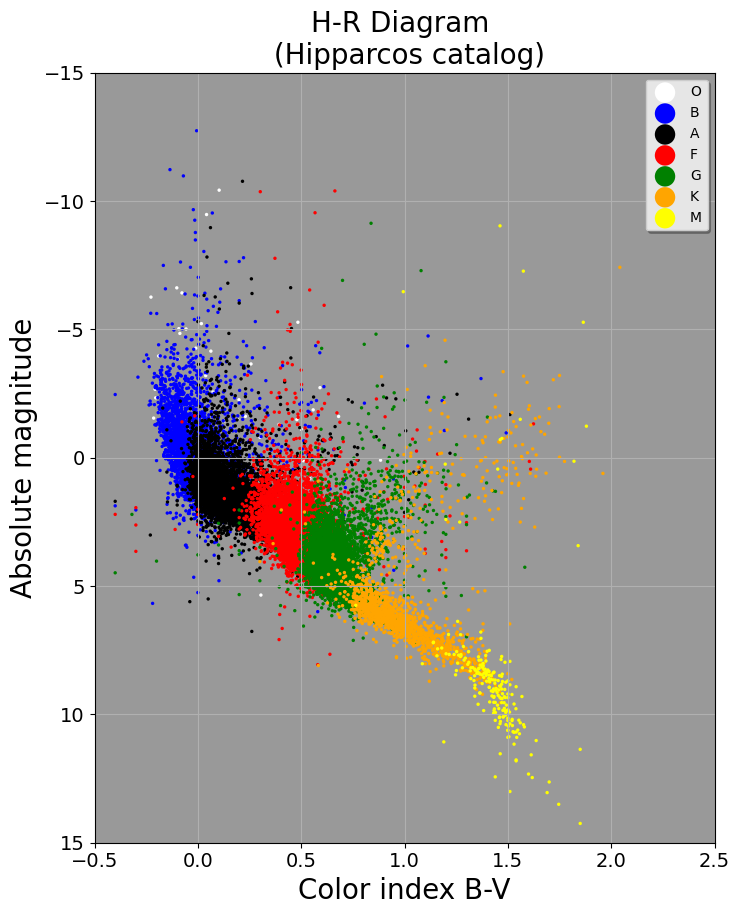

In [12]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111, facecolor='0.6')

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index B-V')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude')
ax.yaxis.label.set_fontsize(20)

#'OBAFGKM'
f = lambda s: s[0]=='O'
b = df_main_seq['SpType'].map(f)
plot_spectral_class(df_main_seq, b,'white', 'O')

f = lambda s: s[0]=='B'
b = df_main_seq['SpType'].map(f)
plot_spectral_class(df_main_seq, b,'blue', 'B')

f = lambda s: s[0]=='A'
b = df_main_seq['SpType'].map(f)
plot_spectral_class(df_main_seq, b,'black', 'A')

f = lambda s: s[0]=='F'
b = df_main_seq['SpType'].map(f)
plot_spectral_class(df_main_seq, b,'red', 'F')

f = lambda s: s[0]=='G'
b = df_main_seq['SpType'].map(f)
plot_spectral_class(df_main_seq, b,'green', 'G')

f = lambda s: s[0]=='K'
b = df_main_seq['SpType'].map(f)
plot_spectral_class(df_main_seq, b,'orange', 'K')

f = lambda s: s[0]=='M'
b = df_main_seq['SpType'].map(f)
plot_spectral_class(df_main_seq, b,'yellow', 'M')

ax.tick_params(axis='both', labelsize=14)
legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')